In [ ]:
# implementing the rolling 3-factor model on a portfolio of assets
# this time, we use portfolio returns instead of a single asset
# we'll use the following stocks: Amazon, Google, Apple, and Microsoft



In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [5]:
# define the parameters
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2010-12-31'
END_DATE = '2020-12-31'

In [18]:
# download the factor related data
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

In [19]:
# download the prices of assets from yahoo finance

asset_df = yf.download(ASSETS, start = START_DATE, end = END_DATE, adjusted = True)

[*********************100%***********************]  4 of 4 completed


In [21]:
# calculate the monthly returns on risky assets
asset_df = asset_df['Adj Close'].resample('M').last().pct_change().dropna()
asset_df.index = asset_df.index.strftime('%Y-%m')

In [23]:
# calculate the portfolio returns
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, WEIGHTS)


In [24]:
asset_df

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2011-01,0.051959,-0.057556,0.010758,-0.006449,-0.000322
2011-02,0.040935,0.021516,0.021720,-0.035806,0.012092
2011-03,-0.013307,0.039471,-0.043430,-0.044771,-0.015509
2011-04,0.004648,0.087048,-0.072704,0.020875,0.009967
2011-05,-0.006569,0.004494,-0.027715,-0.028784,-0.014644
...,...,...,...,...,...
2020-08,0.216569,0.090461,0.101972,0.102752,0.127939
2020-09,-0.102526,-0.087579,-0.100711,-0.067397,-0.089553
2020-10,-0.060012,-0.035754,0.103028,-0.037370,-0.007527


In [26]:
# merge the datasets
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis = 1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['prtf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [28]:
ff_data

,portf_rtn,mkt,smb,hml,rf,prtf_ex_rtn
Date,,,,,,
2011-01,-0.000322,0.0199,-0.0244,0.0077,0.0001,-0.000422
2011-02,0.012092,0.0349,0.0147,0.0124,0.0001,0.011992
2011-03,-0.015509,0.0046,0.0256,-0.0188,0.0001,-0.015609
2011-04,0.009967,0.0290,-0.0032,-0.0248,0.0000,0.009967
2011-05,-0.014644,-0.0127,-0.0065,-0.0200,0.0000,-0.014644
...,...,...,...,...,...,...
2020-08,0.127939,0.0763,-0.0026,-0.0292,0.0001,0.127839
2020-09,-0.089553,-0.0363,0.0002,-0.0262,0.0001,-0.089653
2020-10,-0.007527,-0.0210,0.0441,0.0416,0.0001,-0.007627


In [29]:
# define a function for a rolling n-factor model

def rolling_factor_model(input_data, formula, window_size):
    coeffs = []
    
    for start_index in range(len(input_data) - window_size + 1):
        end_index = start_index + window_size
        ff_model = smf.ols(formula= formula, data = input_data[start_index: end_index]).fit()
        
        coeffs.append(ff_model.params)
        
    coeffs_df = pd.DataFrame(coeffs, index = input_data.index[window_size -1:])
        
    return coeffs_df

In [31]:
# estimate the rolling 3 factor model and plot the results
MODEL_FORMULA = 'prtf_ex_rtn ~ mkt + smb + hml'
resutls_df = rolling_factor_model(ff_data, MODEL_FORMULA, window_size= 60)


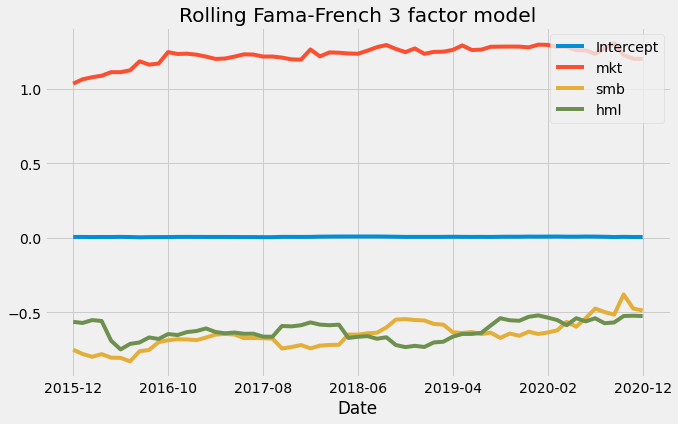

In [39]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (10, 6))
resutls_df.plot(title = 'Rolling Fama-French 3 factor model', ax = ax)
plt.show()